In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

Let's begin with a very simple synthetic dataset.

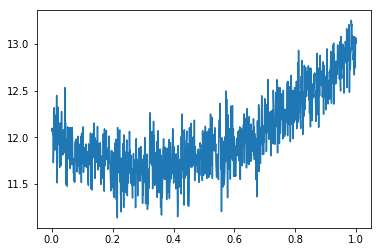

In [81]:
x = np.linspace(0, 1, 1000)  # between 0 and 1
y = 3 * x**2 - 2 * x + 12 + np.random.randn(1000) * 0.2  # a second-order polynomial in x, with some noise
plt.plot(x, y)

We're going to fit this with a standard polynomial regression. We don't know what degree the data is, so we'll cross-validate against that parameter and select the best model.

In [74]:
model = Pipeline([
    ("polynomial_features", PolynomialFeatures()),  # let's take linear x and make polynomial features from it
    ("linear_regression", LinearRegression(fit_intercept=True))  # then a linear regression on the polynomial features
])

# Note that the LinearRegression has fit_intercept=True because we always want to fit an intercept, 
# and this is not a parameter we will ever be varying. We talked about this at the pub - in linear regressions,
# there's no need to scale variables ( LinearRegression does offer a "normalize" argument ), but we want
# to look at the actual coefficients that come out of our fits because they have real-world meaning.
# Therefore, we don't normalize, and as such, we must allow the linear regression to fit an intercept.


# Now we decide on what hyperparameters of the model we allow to vary.
# In this case, we'll vary the degree of the polynomial.
parameters = {
    "polynomial_features__degree": [1, 2, 3, 4, 5],
}

We have a model set out. Now let's fit it and see what the result is like.

In [79]:
x.reshape(-1, 1).shape

(1000, 1)

In [100]:
gridsearch = GridSearchCV(
    model,  # our pipeline
    parameters,  # the parameters of the pipeline that we want to vary
    n_jobs=-1,  # use all cores on our computer
    scoring="neg_mean_squared_error",  # evaluate the model using mean squared error
    cv=5  # and perform 5-fold cross-validation to score the model
)

gridsearch.fit(x.reshape(-1, 1), y)  # sklearn wants *observations* in the first axis and *features* in the second axis

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('polynomial_features', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linear_regression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'polynomial_features__degree': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

So how did we do ?

In [101]:
print("Best MSE score ( lower is better ) : {}".format(gridsearch.best_score_))
print("Best hyperparameters : {}".format(gridsearch.best_params_))

Best MSE score ( lower is better ) : -0.041678423665003454
Best hyperparameters : {'polynomial_features__degree': 2}


Looks like we did well, and our model selected the correct polynomial for us : degree 2.
Let's look at the actual model from within our gridsearch object.

In [102]:
best_model = gridsearch.best_estimator_
print(best_model)

Pipeline(steps=[('polynomial_features', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linear_regression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])


Great, we've recovered a fully tuned pipeline from our gridsearch. Let's make predictions and compare.

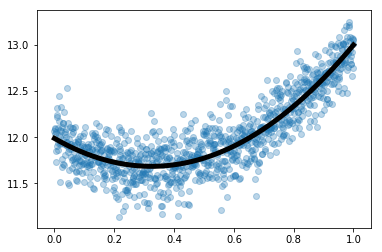

In [103]:
# Predict y_hat from our input features
predictions = best_model.predict(x.reshape(-1, 1))

# Plot to compare
plt.scatter(x, y, alpha=0.3)
plt.plot(x, predictions, lw=5, c="k")

Great. Onto a more complicated dataset, with multiple features.

In [152]:
# Features : number of rooms, number of baths, and square footage of the house
df = pd.DataFrame({
    "rooms": np.random.randint(1, 6, 1000),  # between one and six rooms
    "baths": np.random.randint(1, 4, 1000),  # between one and four baths
    "sqft": np.random.rand(1000) * 5000 # between 0 and 5000 sqft
})

# GROUND TRUTH : house price ( we don't know this relation )
df["price"] = df.rooms * 400 + \
              df.baths * 200 + \
              df.sqft * 10 + \
              df.sqft ** 2 + \
              df.rooms * df.baths * df.sqft * 0.5 + \
              np.random.randn(1000) * 50000

df.head()

,baths,rooms,sqft,price
0,1,5,4360.453783,1.902967e+07
1,1,3,947.878430,9.114322e+05
2,3,4,1177.351904,1.425610e+06
3,1,1,1086.705745,1.225480e+06
4,3,1,868.477002,7.663259e+05


Let's build the same model and grid search over the polynomial degree but also over whether we only want interaction terms or if we want to allow cross-terms. Our ground truth is a degree-3 polynomial with both cross- and interaction-terms.

In [153]:
model = Pipeline([
    ("polynomial_features", PolynomialFeatures()),
    ("linear_regression", LinearRegression(fit_intercept=True))
])

parameters = {
    "polynomial_features__degree": [1, 2, 3, 4, 5],
    "polynomial_features__interaction_only": [True, False]
}

gridsearch = GridSearchCV(
    model,
    parameters,
    n_jobs=-1,
    scoring="neg_mean_squared_error",
    cv=5
)

gridsearch.fit(df[["rooms", "baths", "sqft"]], df.price)

print("Our best model has the parameters : \n{}".format(gridsearch.best_params_))

Our best model has the parameters : 
{'polynomial_features__degree': 2, 'polynomial_features__interaction_only': False}


Let's make predictions and compare to our data.

In [154]:
df["yhat"] = gridsearch.best_estimator_.predict(df[["rooms", "baths", "sqft"]])
df.head(10)

,baths,rooms,sqft,price,yhat
0,1,5,4360.453783,1.902967e+07,1.907838e+07
1,1,3,947.878430,9.114322e+05,9.084875e+05
2,3,4,1177.351904,1.425610e+06,1.405509e+06
3,1,1,1086.705745,1.225480e+06,1.191321e+06
4,3,1,868.477002,7.663259e+05,7.710571e+05
5,3,3,767.182245,6.329318e+05,6.010045e+05
6,3,3,4587.768879,2.110351e+07,2.111758e+07
7,1,1,3364.132313,1.140823e+07,1.135385e+07
8,2,4,4280.046877,1.834843e+07,1.838366e+07
9,3,3,4139.579941,1.722340e+07,1.720109e+07


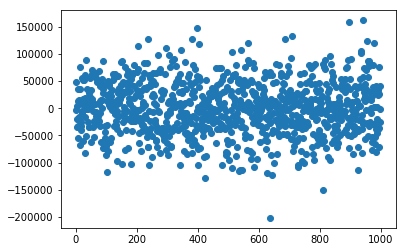

In [164]:
# Residuals
plt.scatter(range(1000), df.yhat - df.price)